# Portfolio Optimization
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import statsmodels.api as sm
from scipy.linalg import sqrtm
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [2]:
class PtfValuation:
    def __init__(self, data):
        self.mu = data.mean(axis=0, numeric_only=True)
        self.cov = data.cov().values
        self.data = data
        self.summary = pd.DataFrame()
    
    def compute_performance(self, weights):
        res = defaultdict(list)
        for i in range(len(weights)):
            weight = weights[i]
            ptf_ret = (self.mu @ weight).flatten()[0]
            ptf_vol = np.sqrt(weight @ self.cov @ weight.T).flatten()[0]
            res['ptf_ann_ret'].append(ptf_ret * 52)
            res['ptf_ann_vol'].append(ptf_vol * np.sqrt(52))
            res['ptf_sr'].append(ptf_ret / ptf_vol * np.sqrt(52))
            # pdb.set_trace()
            tmp = pd.Series(np.r_[1, 1 + np.cumsum(self.data.iloc[:, 1:].values @ weight).flatten()])
            high_level = tmp.rolling(min_periods=1, window=len(tmp), center=False).max()
            res['ptf_mdd'].append(np.min((tmp - high_level).values / high_level.values))
            for idx, col in enumerate(data.columns[1:]):
                res[col].append(weight.flatten()[idx])
        
        self.summary = pd.concat([self.summary, pd.DataFrame(res)], axis=0)
        
    def get_summary(self):
        return self.summary

In [3]:
data = pd.read_csv("aaa.csv")
data.head()

,date,A,B,C,D,E,F,G,H,I,J
0,2014-01-03,0.007597,0.010299,0.000199,0.006900,0.006196,0.000299,0.003000,0.000000,0.003200,0.000598
1,2014-01-10,-0.023402,-0.004004,0.000000,0.016794,-0.010301,-0.012104,-0.006000,-0.006408,-0.006904,-0.001009
2,2014-01-17,0.006299,0.003592,-0.011504,0.001993,0.002295,0.007795,0.004195,-0.004804,0.003194,0.000496
3,2014-01-24,0.032299,0.010294,0.027499,-0.002603,0.020692,0.020696,0.039597,0.023300,0.010993,0.003899
4,2014-01-31,0.000000,0.004698,-0.010101,0.005395,-0.003407,-0.003507,0.010797,-0.005909,0.000000,0.001397


In [4]:
data.index = pd.to_datetime(data.date, format="%Y-%m-%d")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2014-01-03 to 2021-12-10
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    415 non-null    datetime64[ns]
 1   A       415 non-null    float64       
 2   B       415 non-null    float64       
 3   C       415 non-null    float64       
 4   D       415 non-null    float64       
 5   E       415 non-null    float64       
 6   F       415 non-null    float64       
 7   G       415 non-null    float64       
 8   H       415 non-null    float64       
 9   I       415 non-null    float64       
 10  J       415 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 38.9 KB


In [5]:
data.describe()

,A,B,C,D,E,F,G,H,I,J
count,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,0.002227,0.001213,0.003538,0.002735,0.002376,0.001991,0.002683,0.001821,0.001862,0.000850
std,0.020277,0.005967,0.014997,0.008738,0.015709,0.014318,0.018715,0.004447,0.010920,0.002220
min,-0.100101,-0.036206,-0.043502,-0.018903,-0.050002,-0.052104,-0.068401,-0.015802,-0.054403,-0.011208
25%,-0.006451,-0.001501,-0.004502,-0.002409,-0.005353,-0.004602,-0.006301,-0.000405,-0.003102,0.000000
50%,0.002798,0.000800,0.002495,0.001225,0.002396,0.001998,0.002699,0.001494,0.001997,0.000797
75%,0.013749,0.004246,0.011049,0.006347,0.010645,0.010597,0.012549,0.003844,0.007544,0.001799
max,0.080200,0.027695,0.082297,0.047697,0.077198,0.058899,0.072798,0.025800,0.052797,0.013096


In [6]:
res = sm.tsa.arma_order_select_ic(data['F'], ic=["aic", "bic"], trend="nc")
res

{'aic':              0            1            2
 0          NaN -2336.618489 -2336.793084
 1 -2336.761115 -2339.268870 -2337.313976
 2 -2337.132002 -2336.692373 -2336.708145
 3 -2335.133146 -2336.179260 -2331.846736
 4 -2335.408361 -2335.389900 -2341.236829,
 'bic':              0            1            2
 0          NaN -2328.561932 -2324.708249
 1 -2328.704558 -2327.184034 -2321.200862
 2 -2325.047166 -2320.579259 -2316.566752
 3 -2319.020032 -2316.037867 -2307.677065
 4 -2315.266968 -2311.220229 -2313.038879,
 'aic_min_order': (4, 2),
 'bic_min_order': (1, 0)}

In [7]:
r = np.zeros(10)
for idx, col in enumerate(data.columns[1:]):
    order = sm.tsa.arma_order_select_ic(data[col], ic=["aic", "bic"], trend="nc")['bic_min_order']
    model = sm.tsa.arima.ARIMA(data[col], order=(order[0], 0, order[1]))
    res = model.fit(cov_type='robust')
    r[idx] = res.forecast()[0]
    print(f"ARMA order selected by BIC: {col}-{order}")

ARMA order selected by BIC: A-(1, 0)
ARMA order selected by BIC: B-(1, 2)
ARMA order selected by BIC: C-(1, 1)
ARMA order selected by BIC: D-(1, 1)
ARMA order selected by BIC: E-(2, 0)
ARMA order selected by BIC: F-(1, 0)
ARMA order selected by BIC: G-(2, 0)
ARMA order selected by BIC: H-(1, 1)
ARMA order selected by BIC: I-(1, 0)
ARMA order selected by BIC: J-(1, 2)


In [8]:
cov = data.cov().values

## Portfolio Assumption

- Long-only, Fully-invested
- Long-Short, Fully-invested
- Long-only, Fully-invested, No group of 3 assets contains more than 80% of the total investment

## Classical (Markowitz) portfolio optimization

Classical (Markowitz) portfolio optimization solves the optimization problem

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{s.t.} & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}

where $w \in {\bf R}^n$ is the optimization variable, $\cal W$ is a set of allowed portfolios (e.g., ${\cal W} = {\bf R}_+^n$ for a long only portfolio), and $\gamma >0$ is the *risk aversion parameter*.


### Assumptions 1: Long-only, Fully-invested

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{s.t.} & {\bf 1}^T w = 1, \quad w \geq 0
\end{array}

In [9]:
r = r.reshape(-1, 1)
n = len(data.columns[1:])

w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = r.T @ w 
risk = cp.quad_form(w, cov)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])

In [10]:
SAMPLES = 100
risks = np.zeros(SAMPLES)
rets = np.zeros(SAMPLES)
weights = np.zeros((SAMPLES, n))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risks[i] = cp.sqrt(risk).value
    rets[i] = ret.value
    weights[i] = w.value

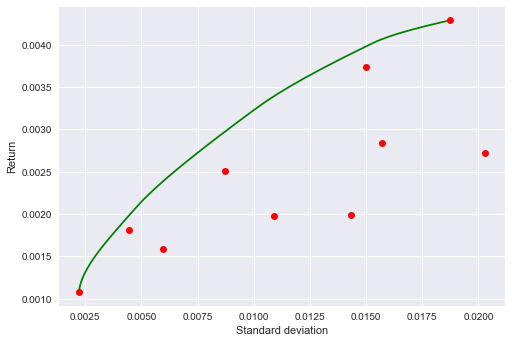

In [11]:
# plot for trade-off curve
fig, ax = plt.subplots()
ax.plot(risks, rets, 'g-')
    
for i in range(n):
    ax.plot(cp.sqrt(cov[i,i]).value, r[i], 'ro')
ax.set_xlabel('Standard deviation')
ax.set_ylabel('Return')
plt.show()

In [12]:
gamma.value = 25
prob.solve()
risks = cp.sqrt(risk).value
rets = ret.value
weights = w.value

In [13]:
results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))

In [14]:
long_only = results.get_summary().round(decimals=8)
long_only.drop_duplicates(inplace=True)

In [15]:
long_only

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.112389,0.037717,2.979827,-0.017487,-0.0,0.0,0.0,0.304501,-0.0,-0.0,0.072347,0.623153,0.0,0.0


### Assumptions 2: Long-Short, Fully-invested

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{s.t.} & {\bf 1}^T w = 1
\end{array}

In [16]:
w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = r.T @ w 
risk = cp.quad_form(w, cov)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1])

In [17]:
gamma.value = 25
prob.solve()
risks = cp.sqrt(risk).value
rets = ret.value
weights = w.value

results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_short = results.get_summary().round(decimals=8)
long_short.drop_duplicates(inplace=True)

In [18]:
long_short

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.143401,0.051899,2.763074,-0.020681,-0.091257,0.128881,0.350618,0.168292,0.074778,-0.681993,0.420027,0.852351,-0.203813,-0.017886


### Assumptions 3: Long-only, Fully-invested, No group of 3 assets contains more than 80% of the total investment

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{s.t.} & {\bf 1}^T w = 1, \\
            & w \geq 0, \\
            & 3\alpha + \sum_{i=1}^{n} u_{i} \leq 0.8\sum_{i=1}^{n}w_{i}, \\
            & u \geq 0, \\
            & u_{i} \geq w_{i} - \alpha, \quad i=1,\ldots,n
\end{array}

where $w \in {\bf R}^n,u \in {\bf R}^n, \alpha \in {\bf R}$ are the optimization variables.

In [19]:
w = cp.Variable(n)
u = cp.Variable(n)
alpha = cp.Variable()

gamma = cp.Parameter(nonneg=True)
ret = r.T @ w 
risk = cp.quad_form(w, cov)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0,
                0.8 * cp.sum(w) >= 3 * alpha + cp.sum(u),
                u >= 0,
                u - w >= -1 * alpha])

In [20]:
gamma.value = 25
prob.solve()
risks = cp.sqrt(risk).value
rets = ret.value
weights = w.value

results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_only_div = results.get_summary().round(decimals=8)
long_only_div.drop_duplicates(inplace=True)

In [21]:
long_only_div

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.109302,0.038974,2.804465,-0.018838,-0.0,0.073259,0.053482,0.264669,-0.0,-0.0,0.073259,0.462072,0.0,0.073259


## Risk Parity portfolio optimization
### Assumptions 1: Long-only, Fully-invested

\begin{array}{ll} \mbox{minimize} & w^T\Sigma w\\
\mbox{s.t.} & {\bf 1}^T w = 1, \\
            & w \geq 0, \\
            &  \begin{Vmatrix} 2\sqrt{\theta_{i}}Rw \\w_{i} - (\Sigma w)_{i} \end{Vmatrix}_2 \leq w_i + (\Sigma w)_i, \quad i=1,\ldots,n
\end{array}

where $R$ is any matrix such that $\Sigma = RR^T$, $\theta$ is the given set of parameters that sum to one, which difines our risk budgets, and it is set to $[\tfrac{1}{10}, \ldots, \tfrac{1}{10}]^T$ in this case (risk parity or equal risk contributions).

In [22]:
R = np.linalg.cholesky(cov)

w = cp.Variable(n)
risk = cp.quad_form(w, cov)
soc_constraints = [
      cp.SOC(w[i] + (cov @ w)[i], cp.hstack([2 * cp.sqrt(1 / n) * R @ w, w[i] - (cov @ w)[i]])) for i in range(n)
]
prob = cp.Problem(cp.Minimize(risk), 
               [cp.sum(w) == 1, 
                w >= 0] + soc_constraints)

In [23]:
prob.solve()
risks = cp.sqrt(risk).value
rets = ret.value
weights = w.value

In [24]:
results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_only_rp = results.get_summary().round(decimals=8)
long_only_rp.drop_duplicates(inplace=True)

In [25]:
long_only_rp

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.048128,0.017659,2.725443,-0.059421,0.002302,0.012963,0.003771,0.012583,0.00336,0.003449,0.002929,0.015146,0.004223,0.939274


### Assumptions 1: Long-Short, Fully-invested

\begin{array}{ll} \mbox{minimize} & w^T\Sigma w\\
\mbox{s.t.} & {\bf 1}^T w = 1, \\
            &  \begin{Vmatrix} 2\sqrt{\theta_{i}}Rw \\w_{i} - (\Sigma w)_{i} \end{Vmatrix}_2 \leq w_i + (\Sigma w)_i, \quad i=1,\ldots,n
\end{array}

where $R$ is any matrix such that $\Sigma = RR^T$, $\theta$ is the given set of parameters that sum to one, which difines our risk budgets, and it is set to $[\tfrac{1}{10}, \ldots, \tfrac{1}{10}]^T$ in this case (risk parity or equal risk contributions).

In [26]:
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
soc_constraints = [
      cp.SOC(w[i] + (cov @ w)[i], cp.hstack([2 * cp.sqrt(1 / n) * R @ w, w[i] - (cov @ w)[i]])) for i in range(n)
]
prob = cp.Problem(cp.Minimize(risk), 
               [cp.sum(w) == 1] + soc_constraints)

In [27]:
prob.solve()
risks = cp.sqrt(risk).value
rets = ret.value
weights = w.value

In [28]:
results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_short_rp = results.get_summary().round(decimals=8)
long_short_rp.drop_duplicates(inplace=True)
long_short_rp

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.048128,0.017659,2.725449,-0.05942,0.002302,0.012964,0.003771,0.012584,0.00336,0.003449,0.00293,0.015149,0.004223,0.939269


### Assumptions 3: Long-only, Fully-invested, No group of 3 assets contains more than 80% of the total investment

\begin{array}{ll} \mbox{minimize} & w^T\Sigma w\\
\mbox{s.t.} & {\bf 1}^T w = 1, \\
            & w \geq 0, \\
            & 3\alpha + \sum_{i=1}^{n} u_{i} \leq 0.8\sum_{i=1}^{n}w_{i}, \\
            & u \geq 0, \\
            & u_{i} \geq w_{i} - \alpha, \quad i=1,\ldots,n \\
            &  \begin{Vmatrix} 2\sqrt{\theta_{i}}Rw \\w_{i} - (\Sigma w)_{i} \end{Vmatrix}_2 \leq w_i + (\Sigma w)_i, \quad i=1,\ldots,n
\end{array}

where $w \in {\bf R}^n,u \in {\bf R}^n, \alpha \in {\bf R}$ are the optimization variables.

In [29]:
w = cp.Variable(n)
u = cp.Variable(n)
alpha = cp.Variable()

risk = cp.quad_form(w, cov)
soc_constraints = [
      cp.SOC(w[i] + (cov @ w)[i], cp.hstack([2 * cp.sqrt(1 / n) * R @ w, w[i] - (cov @ w)[i]])) for i in range(n)
]
prob = cp.Problem(cp.Minimize(risk), 
               [cp.sum(w) == 1,
                w >= 0,
                0.8 * cp.sum(w) >= 3 * alpha + cp.sum(u),
                u >= 0,
                u - w >= -1 * alpha] + soc_constraints)

In [30]:
prob.solve()
risks = cp.sqrt(risk).value
rets = ret.value
weights = w.value

In [31]:
results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_only_div_rp = results.get_summary().round(decimals=8)
long_only_div_rp.drop_duplicates(inplace=True)
long_only_div_rp

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.068714,0.025297,2.71629,-0.032933,0.003394,0.114493,0.005061,0.114493,0.004624,0.004895,0.004146,0.114493,0.063388,0.571013


## Sharpe Ratio portfolio optimization
### Assumptions 1: Long-only, Fully-invested

\begin{array}{ll} \mbox{maximize} & \mu^T z - \alpha r_{f}\\
\mbox{s.t.} & {\bf 1}^T z = 1, \\
            & \mu^T z \geq \alpha r_f, \\
            & z \geq 0, \\
            & \begin{Vmatrix} Rz \end{Vmatrix}_2  \leq 1
\end{array}

where $R$ is any matrix such that $\Sigma = RR^T$. $z \in {\bf R}^n,\alpha > 0$ are the variables to be optimized, and the weight $w$ is given by $w = \tfrac{z}{\alpha}$. $r_{f} \in {\bf R}$ is the risk-free rate.

In [32]:
R = sqrtm(cov)

z = cp.Variable(n)
alpha = cp.Variable(nonneg=True)
rf = 0.00001

prob = cp.Problem(cp.Maximize(r.T @ z - alpha * rf), 
               [cp.sum(z) == alpha,
                r.T @ z >= alpha * rf,
                z >= 0,
                cp.SOC(1, R @ z)])

In [33]:
prob.solve()
alpha_ = alpha.value
z_ = z.value
weights = z_ / alpha_

In [34]:
results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_only_sr = results.get_summary().round(decimals=8)
long_only_sr.drop_duplicates(inplace=True)
long_only_sr

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.060515,0.018097,3.343971,-0.035635,0.0,3.000000e-08,0.0,0.067052,0.0,0.0,0.0,0.192719,0.0,0.740229


### Assumptions 2: Long-Short, Fully-invested

\begin{array}{ll} \mbox{maximize} & \mu^T z - \alpha r_{f}\\
\mbox{s.t.} & {\bf 1}^T z = 1, \\
            & \mu^T z \geq \alpha r_f, \\
            & \begin{Vmatrix} Rz \end{Vmatrix}_2  \leq 1
\end{array}

where $R$ is any matrix such that $\Sigma = RR^T$. $z \in {\bf R}^n,\alpha > 0$ are the variables to be optimized, and the weight $w$ is given by $w = \tfrac{z}{\alpha}$. $r_{f} \in {\bf R}$ is the risk-free rate.

In [35]:
R = sqrtm(cov)

z = cp.Variable(n)
alpha = cp.Variable(nonneg=True)
rf = 0.00001

prob = cp.Problem(cp.Maximize(r.T @ z - alpha * rf), 
               [cp.sum(z) == alpha,
                r.T @ z >= alpha * rf,
                cp.SOC(1, R @ z)])

In [36]:
prob.solve()
alpha_ = alpha.value
z_ = z.value
weights = z_ / alpha_

results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_short_sr = results.get_summary().round(decimals=8)
long_short_sr.drop_duplicates(inplace=True)
long_short_sr

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.046512,0.009136,5.090836,-0.035018,-0.108254,0.036038,0.01449,0.004565,0.034322,-0.059434,0.029595,0.119521,-0.022086,0.951241


## Maximum Decorrelation portfolio optimization
### Assumptions 1: Long-only, Fully-invested

Maximum Decorrelation described by (Christoffersen et al. 2010) is closely related to Minimum Variance and Maximum Diversification, but applies to the case where an investor believes all assets have similar returns and volatility, but heterogeneous correlations. 

The Maximum Decorrelation portfolio is found by solving for:

\begin{array}{ll} \mbox{minimize} & w^T\Delta w\\
\mbox{s.t.} & {\bf 1}^T w = 1, \\
            & w \geq 0
\end{array}

where $\Delta \in {\bf R}^{n\times n}$ is the correlation matrix.

In [37]:
corr = data.corr().values

w = cp.Variable(n)
risk = cp.quad_form(w, corr)

prob = cp.Problem(cp.Minimize(risk), 
               [cp.sum(w) == 1, 
                w >= 0])

In [38]:
prob.solve()
risks = cp.sqrt(risk).value
weights = w.value
results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_only_corr = results.get_summary().round(decimals=8)
long_only_corr.drop_duplicates(inplace=True)
long_only_corr

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.105593,0.044786,2.35774,-0.030545,-0.0,0.223562,-0.0,0.367727,-0.0,0.0,0.157635,0.121052,-0.0,0.130024


### Assumptions 2: Long-Short, Fully-invested

\begin{array}{ll} \mbox{minimize} & w^T\Delta w\\
\mbox{s.t.} & {\bf 1}^T w = 1
\end{array}

where $\Delta \in {\bf R}^{n\times n}$ is the correlation matrix.

In [39]:
w = cp.Variable(n)
risk = cp.quad_form(w, corr)

prob = cp.Problem(cp.Minimize(risk), 
               [cp.sum(w) == 1])

prob.solve()
risks = cp.sqrt(risk).value
weights = w.value
results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_short_corr = results.get_summary().round(decimals=8)
long_short_corr.drop_duplicates(inplace=True)
long_short_corr

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.120052,0.076508,1.569149,-0.073169,0.595996,0.221985,0.046694,0.408327,0.087823,-0.028926,0.197119,0.103707,-0.889546,0.256821


## Maximum Diversification Portfolio Optimization
### Assumptions 1: Long-only, Fully-invested

(Choueifaty and Coignard 2008) proposed that markets are risk-efficient, such that investments will produce returns in proportion to their total risk, as measured by volatility. This differs from CAPM, which assumes returns are proportional to non-diversifiable (i.e. systematic) risk. Choueifaty et al. described their method as Maximum Diversification (Maximum Diversification). Consistent with the view that returns are directly proportional to volatility, the Maximum Diversification optimization substitutes asset volatilities for returns in a maximum Sharpe ratio optimization, taking the following form.

\begin{array}{ll} \mbox{maximize} & \sigma^T z - \alpha r_{f}\\
\mbox{s.t.} & {\bf 1}^T z = 1, \\
            & z \geq 0, \\
            & \sigma^T z \geq \alpha r_f, \\
            & \begin{Vmatrix} Rz \end{Vmatrix}_2  \leq 1
\end{array}

where $R$ is any matrix such that $\Sigma = RR^T$. $z \in {\bf R}^n,\alpha > 0$ are the variables to be optimized, and the weight $w$ is given by $w = \tfrac{z}{\alpha}$. $r_{f} \in {\bf R}$ is the risk-free rate. $\sigma \in {\bf R}^n$ is the volatility vector of asset.

In [40]:
R = sqrtm(cov)
sigma = np.sqrt(np.diag(cov)).reshape(-1, 1)

z = cp.Variable(n)
alpha = cp.Variable(nonneg=True)
rf = 0.00001

prob = cp.Problem(cp.Maximize(sigma.T @ z - alpha * rf), 
               [cp.sum(z) == alpha,
                sigma.T @ z >= alpha * rf,
                z >= 0,
                cp.SOC(1, R @ z)])

In [41]:
prob.solve()
alpha_ = alpha.value
z_ = z.value
weights = z_ / alpha_

results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_only_maxdiv = results.get_summary().round(decimals=8)
long_only_maxdiv.drop_duplicates(inplace=True)
long_only_maxdiv

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.08508,0.030796,2.762662,-0.020979,8.000000e-08,0.217809,0.000001,0.245199,1.300000e-07,1.000000e-07,0.050108,0.157606,5.000000e-08,0.329275


### Assumptions 2: Long-Short, Fully-invested

\begin{array}{ll} \mbox{maximize} & \sigma^T z - \alpha r_{f}\\
\mbox{s.t.} & {\bf 1}^T z = 1, \\
            & \sigma^T z \geq \alpha r_f, \\
            & \begin{Vmatrix} Rz \end{Vmatrix}_2  \leq 1
\end{array}

where $R$ is any matrix such that $\Sigma = RR^T$. $z \in {\bf R}^n,\alpha > 0$ are the variables to be optimized, and the weight $w$ is given by $w = \tfrac{z}{\alpha}$. $r_{f} \in {\bf R}$ is the risk-free rate. $\sigma \in {\bf R}^n$ is the volatility vector of asset.

In [42]:
z = cp.Variable(n)
alpha = cp.Variable(nonneg=True)
rf = 0.00001

prob = cp.Problem(cp.Maximize(sigma.T @ z - alpha * rf), 
               [cp.sum(z) == alpha,
                sigma.T @ z >= alpha * rf,
                cp.SOC(1, R @ z)])

In [43]:
prob.solve()
alpha_ = alpha.value
z_ = z.value
weights = z_ / alpha_

results = PtfValuation(data)
results.compute_performance(weights.reshape(1, -1))
long_short_maxdiv = results.get_summary().round(decimals=8)
long_short_maxdiv.drop_duplicates(inplace=True)
long_short_maxdiv

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J
0,0.077082,0.027919,2.760923,-0.027421,0.161757,0.201274,0.01713,0.253737,0.029692,-0.010726,0.05716,0.12524,-0.441866,0.606601


## Summary (Result)

In [44]:
long_only_ptfs = pd.concat([long_only,
                            long_only_rp,
                            long_only_sr,
                            long_only_corr,
                            long_only_maxdiv], axis=0)
long_only_ptfs['comment'] = ["Mean Variance Opt", "Risk Parity Opt", "Sharpe Ratio Opt", "Maximum Decorrelation Opt", "Maximum Diversification Opt"]
long_only_ptfs     

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J,comment
0,0.112389,0.037717,2.979827,-0.017487,-0.000000e+00,0.000000e+00,0.000000,0.304501,-0.000000e+00,-0.000000e+00,0.072347,0.623153,0.000000e+00,0.000000,Mean Variance Opt
0,0.048128,0.017659,2.725443,-0.059421,2.301560e-03,1.296311e-02,0.003771,0.012583,3.359900e-03,3.449250e-03,0.002929,0.015146,4.222650e-03,0.939274,Risk Parity Opt
0,0.060515,0.018097,3.343971,-0.035635,0.000000e+00,3.000000e-08,0.000000,0.067052,0.000000e+00,0.000000e+00,0.000000,0.192719,0.000000e+00,0.740229,Sharpe Ratio Opt
0,0.105593,0.044786,2.357740,-0.030545,-0.000000e+00,2.235617e-01,-0.000000,0.367727,-0.000000e+00,0.000000e+00,0.157635,0.121052,-0.000000e+00,0.130024,Maximum Decorrelation Opt
0,0.085080,0.030796,2.762662,-0.020979,8.000000e-08,2.178093e-01,0.000001,0.245199,1.300000e-07,1.000000e-07,0.050108,0.157606,5.000000e-08,0.329275,Maximum Diversification Opt


In [45]:
long_short_ptfs = pd.concat([long_short,
                             long_short_rp,
                             long_short_sr,
                             long_short_corr,
                             long_short_maxdiv], axis=0)
long_short_ptfs['comment'] = ["Mean Variance Opt", "Risk Parity Opt", "Sharpe Ratio Opt", "Maximum Decorrelation Opt", "Maximum Diversification Opt"]
long_short_ptfs    

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J,comment
0,0.143401,0.051899,2.763074,-0.020681,-0.091257,0.128881,0.350618,0.168292,0.074778,-0.681993,0.420027,0.852351,-0.203813,-0.017886,Mean Variance Opt
0,0.048128,0.017659,2.725449,-0.059420,0.002302,0.012964,0.003771,0.012584,0.003360,0.003449,0.002930,0.015149,0.004223,0.939269,Risk Parity Opt
0,0.046512,0.009136,5.090836,-0.035018,-0.108254,0.036038,0.014490,0.004565,0.034322,-0.059434,0.029595,0.119521,-0.022086,0.951241,Sharpe Ratio Opt
0,0.120052,0.076508,1.569149,-0.073169,0.595996,0.221985,0.046694,0.408327,0.087823,-0.028926,0.197119,0.103707,-0.889546,0.256821,Maximum Decorrelation Opt
0,0.077082,0.027919,2.760923,-0.027421,0.161757,0.201274,0.017130,0.253737,0.029692,-0.010726,0.057160,0.125240,-0.441866,0.606601,Maximum Diversification Opt


In [46]:
long_only_div_ptfs = pd.concat([long_only_div,
                                long_only_div_rp,
                                long_only_corr,
                                long_only_maxdiv], axis=0)
long_only_div_ptfs['comment'] = ["Mean Variance Opt", "Risk Parity Opt", "Maximum Decorrelation Opt", "Maximum Diversification Opt"]
long_only_div_ptfs

,ptf_ann_ret,ptf_ann_vol,ptf_sr,ptf_mdd,A,B,C,D,E,F,G,H,I,J,comment
0,0.109302,0.038974,2.804465,-0.018838,-0.000000e+00,0.073259,0.053482,0.264669,-0.000000e+00,-0.000000e+00,0.073259,0.462072,0.000000e+00,0.073259,Mean Variance Opt
0,0.068714,0.025297,2.716290,-0.032933,3.393520e-03,0.114493,0.005061,0.114493,4.623520e-03,4.894600e-03,0.004146,0.114493,6.338837e-02,0.571013,Risk Parity Opt
0,0.105593,0.044786,2.357740,-0.030545,-0.000000e+00,0.223562,-0.000000,0.367727,-0.000000e+00,0.000000e+00,0.157635,0.121052,-0.000000e+00,0.130024,Maximum Decorrelation Opt
0,0.085080,0.030796,2.762662,-0.020979,8.000000e-08,0.217809,0.000001,0.245199,1.300000e-07,1.000000e-07,0.050108,0.157606,5.000000e-08,0.329275,Maximum Diversification Opt
